# Flair NLP Framework

In [38]:
!pip install flair
!pip install torch
!pip install importlib-metadata
!pip install emoji
!pip install nltk


In [39]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

import torch
torch.cuda.is_available()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


False

# Paths

In [40]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_train = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/train_tweet.csv" 
path_test = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/test_tweet.csv" 

path_flair = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/"
path_flair_train = path_flair+"train.csv"
path_flair_test = path_flair+"test.csv"
path_flair_dev = path_flair+"dev.csv"

path_model_distilbert = parent_path+"team project/codes/models/flair_models"

# Data Exploration

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


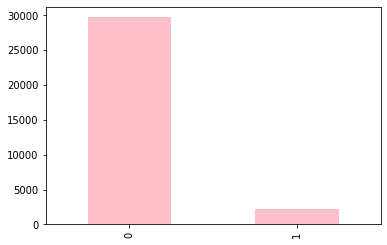

In [11]:
data = pd.read_csv(path_train)

data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))
data.head()

# Fast text format and split Dataset

In [12]:
data['label'] = '__label__' + data['label'].astype(str)

train, test = train_test_split(data, test_size=0.2, random_state = 453, stratify=data['label'])
test, dev = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

train.to_csv(path_flair_train, sep='\t', index = False, header = False)
test.to_csv(path_flair_test, sep='\t', index = False, header = False)
dev.to_csv(path_flair_dev, sep='\t', index = False, header = False)

train.head(5)

,id,label,tweet
24478,24479,__label__0,let me guess... the bon voyage thing is on vli...
15737,15738,__label__0,@user had to go home today @user (named after...
67,68,__label__0,i'm sure they are just as happy.... ðð½ð...
9148,9149,__label__0,@user @user and i thought you were mad... /:
21246,21247,__label__0,this time next week i'd have finished work for...


# Train Classifier

In [14]:
#1. get the corpus
column_name_map = {2: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',    # tab-separated files
                                         label_type= "label")
print(corpus)

#2. what label do we want to predict?
label_type = 'label'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

# 4. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type)

# 6. initialize trainer
trainer = ModelTrainer(classifier, corpus)

# 7. run training with fine-tuning
trainer.fine_tune(path_model_distilbert,
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=5,
                  write_weights = True, #maybe
                  )


2022-05-08 21:21:27,520 Reading data from /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape
2022-05-08 21:21:27,525 Train: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/train.csv
2022-05-08 21:21:27,529 Dev: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/dev.csv
2022-05-08 21:21:27,533 Test: /content/drive/My Drive/team project/data set/dataset search/Twitter Sentiment Analysis/flair_shape/test.csv
Corpus: 25568 train + 3196 dev + 3195 test sentences
2022-05-08 21:21:27,675 Computing label dictionary. Progress:


25568it [00:09, 2579.27it/s]

2022-05-08 21:21:37,597 Dictionary created for label 'label' with 3 values: __label__0 (seen 23774 times), __label__1 (seen 1794 times)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

2022-05-08 21:22:07,880 ----------------------------------------------------------------------------------------------------
2022-05-08 21:22:07,886 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

100%|██████████| 799/799 [00:07<00:00, 106.05it/s]

2022-05-08 21:27:47,061 Evaluating as a multi-label problem: False
2022-05-08 21:27:47,092 DEV : loss 0.03622155264019966 - f1-score (micro avg)  0.9637


2022-05-08 21:27:48,531 BAD EPOCHS (no improvement): 4
2022-05-08 21:27:48,538 ----------------------------------------------------------------------------------------------------
2022-05-08 21:28:21,035 epoch 2 - iter 639/6392 - loss 0.01849829 - samples/sec: 81.08 - lr: 0.000043
2022-05-08 21:28:53,666 epoch 2 - iter 1278/6392 - loss 0.01814880 - samples/sec: 80.77 - lr: 0.000042
2022-05-08 21:29:26,328 epoch 2 - iter 1917/6392 - loss 0.01910385 - samples/sec: 80.66 - lr: 0.000041
2022-05-08 21:29:59,104 epoch 2 - iter 2556/6392 - loss 0.01951535 - samples/sec: 81.03 - lr: 0.000040
2022-05-08 21:30:31,608 epoch 2 - iter 3195/6392 - loss 0.02012897 - samples/sec: 81.01 - lr: 0.000039
2022-05-08 21:31:04,042 epoch 2 - iter 3834/6392 - loss 0.02054592 - samples/sec: 81.24 - lr: 0.000038
2022-05-08 21:31:36,643 epoch 2 - iter 4473/6392 - loss 0.02045140 - samples/sec: 80.80 - lr: 0.000037
2022-05-08 21:32:09,235 epoch 2 - iter 5112/6392 - loss 0.02007296 - samples/sec: 80.90 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 103.40it/s]

2022-05-08 21:33:21,992 Evaluating as a multi-label problem: False
2022-05-08 21:33:22,020 DEV : loss 0.03333432972431183 - f1-score (micro avg)  0.9665


2022-05-08 21:33:23,599 BAD EPOCHS (no improvement): 4
2022-05-08 21:33:23,606 ----------------------------------------------------------------------------------------------------
2022-05-08 21:33:55,999 epoch 3 - iter 639/6392 - loss 0.00800913 - samples/sec: 81.27 - lr: 0.000032
2022-05-08 21:34:28,602 epoch 3 - iter 1278/6392 - loss 0.00679460 - samples/sec: 80.77 - lr: 0.000031
2022-05-08 21:35:01,192 epoch 3 - iter 1917/6392 - loss 0.00809445 - samples/sec: 80.88 - lr: 0.000030
2022-05-08 21:35:33,862 epoch 3 - iter 2556/6392 - loss 0.00832108 - samples/sec: 80.66 - lr: 0.000029
2022-05-08 21:36:06,427 epoch 3 - iter 3195/6392 - loss 0.00792534 - samples/sec: 80.93 - lr: 0.000028
2022-05-08 21:36:38,924 epoch 3 - iter 3834/6392 - loss 0.00798948 - samples/sec: 81.09 - lr: 0.000027
2022-05-08 21:37:11,566 epoch 3 - iter 4473/6392 - loss 0.00797919 - samples/sec: 80.77 - lr: 0.000026
2022-05-08 21:37:44,146 epoch 3 - iter 5112/6392 - loss 0.00782541 - samples/sec: 80.91 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 101.15it/s]

2022-05-08 21:38:57,214 Evaluating as a multi-label problem: False
2022-05-08 21:38:57,240 DEV : loss 0.05262608453631401 - f1-score (micro avg)  0.9681


2022-05-08 21:38:58,544 BAD EPOCHS (no improvement): 4
2022-05-08 21:38:58,550 ----------------------------------------------------------------------------------------------------
2022-05-08 21:39:31,094 epoch 4 - iter 639/6392 - loss 0.00280934 - samples/sec: 80.93 - lr: 0.000021
2022-05-08 21:40:03,643 epoch 4 - iter 1278/6392 - loss 0.00283420 - samples/sec: 80.90 - lr: 0.000020
2022-05-08 21:40:36,257 epoch 4 - iter 1917/6392 - loss 0.00312415 - samples/sec: 80.75 - lr: 0.000019
2022-05-08 21:41:09,000 epoch 4 - iter 2556/6392 - loss 0.00337401 - samples/sec: 80.52 - lr: 0.000018
2022-05-08 21:41:41,577 epoch 4 - iter 3195/6392 - loss 0.00353809 - samples/sec: 80.91 - lr: 0.000017
2022-05-08 21:42:14,214 epoch 4 - iter 3834/6392 - loss 0.00374718 - samples/sec: 80.75 - lr: 0.000016
2022-05-08 21:42:46,778 epoch 4 - iter 4473/6392 - loss 0.00353175 - samples/sec: 80.89 - lr: 0.000014
2022-05-08 21:43:19,588 epoch 4 - iter 5112/6392 - loss 0.00323462 - samples/sec: 80.35 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 103.59it/s]

2022-05-08 21:44:33,438 Evaluating as a multi-label problem: False
2022-05-08 21:44:33,462 DEV : loss 0.08230684697628021 - f1-score (micro avg)  0.9659


2022-05-08 21:44:34,772 BAD EPOCHS (no improvement): 4
2022-05-08 21:44:34,780 ----------------------------------------------------------------------------------------------------
2022-05-08 21:45:07,392 epoch 5 - iter 639/6392 - loss 0.00103609 - samples/sec: 80.78 - lr: 0.000010
2022-05-08 21:45:39,878 epoch 5 - iter 1278/6392 - loss 0.00158852 - samples/sec: 81.09 - lr: 0.000009
2022-05-08 21:46:12,587 epoch 5 - iter 1917/6392 - loss 0.00118403 - samples/sec: 80.56 - lr: 0.000008
2022-05-08 21:46:45,231 epoch 5 - iter 2556/6392 - loss 0.00113113 - samples/sec: 80.81 - lr: 0.000007
2022-05-08 21:47:17,873 epoch 5 - iter 3195/6392 - loss 0.00114842 - samples/sec: 80.75 - lr: 0.000006
2022-05-08 21:47:50,522 epoch 5 - iter 3834/6392 - loss 0.00096830 - samples/sec: 80.75 - lr: 0.000004
2022-05-08 21:48:23,262 epoch 5 - iter 4473/6392 - loss 0.00088957 - samples/sec: 81.19 - lr: 0.000003
2022-05-08 21:48:55,714 epoch 5 - iter 5112/6392 - loss 0.00096363 - samples/sec: 81.17 - lr: 0.0000

100%|██████████| 799/799 [00:07<00:00, 103.46it/s]


2022-05-08 21:50:09,008 Evaluating as a multi-label problem: False
2022-05-08 21:50:09,035 DEV : loss 0.08695580810308456 - f1-score (micro avg)  0.9643
2022-05-08 21:50:10,384 BAD EPOCHS (no improvement): 4
2022-05-08 21:50:16,761 ----------------------------------------------------------------------------------------------------
2022-05-08 21:50:16,768 Testing using last state of model ...


100%|██████████| 799/799 [00:07<00:00, 103.96it/s]

2022-05-08 21:50:24,475 Evaluating as a multi-label problem: False
2022-05-08 21:50:24,499 0.9674	0.9674	0.9674	0.9674
2022-05-08 21:50:24,500 
Results:
- F-score (micro) 0.9674
- F-score (macro) 0.8645
- Accuracy 0.9674

By class:
              precision    recall  f1-score   support

  __label__0     0.9764    0.9889    0.9826      2971
  __label__1     0.8226    0.6830    0.7463       224

    accuracy                         0.9674      3195
   macro avg     0.8995    0.8360    0.8645      3195
weighted avg     0.9656    0.9674    0.9660      3195

2022-05-08 21:50:24,503 ----------------------------------------------------------------------------------------------------


{'dev_loss_history': [0.03622155264019966,
  0.03333432972431183,
  0.05262608453631401,
  0.08230684697628021,
  0.08695580810308456],
 'dev_score_history': [0.9637046307884856,
  0.9665206508135169,
  0.9680851063829787,
  0.9658948685857321,
  0.9643304130162703],
 'test_score': 0.9674491392801252,
 'train_loss_history': [0.040501677848289085,
  0.01964144259513189,
  0.007939627105616067,
  0.0029286713753449794,
  0.0007758039587756901]}

In [41]:
new_clf = TextClassifier.load(path_model_distilbert+'/final-model.pt')

2022-05-08 22:26:04,801 loading file /content/drive/My Drive/team project/codes/models/flair_models/final-model.pt


In [43]:
pred1 = Sentence("That girl is stupid")
pred2 = Sentence("This is a good material")

In [44]:
new_clf.predict(pred1)

In [46]:
pred1

Sentence: "That girl is stupid" → __label__0 (0.9824)

In [52]:
pred1.labels[0].to_dict()['value'] 

'__label__0'

2022-05-08 22:42:40,382 ----------------------------------------------------------------------------------------------------
2022-05-08 22:42:40,384 WARNING: No LOSS found for test split in this data.
2022-05-08 22:42:40,386 Are you sure you want to plot LOSS and not another value?
2022-05-08 22:42:40,391 ----------------------------------------------------------------------------------------------------
2022-05-08 22:42:40,430 ----------------------------------------------------------------------------------------------------
2022-05-08 22:42:40,433 WARNING: No F1 found for test split in this data.
2022-05-08 22:42:40,437 Are you sure you want to plot F1 and not another value?
2022-05-08 22:42:40,440 ----------------------------------------------------------------------------------------------------
2022-05-08 22:42:42,656 Loss and F1 plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/training.png


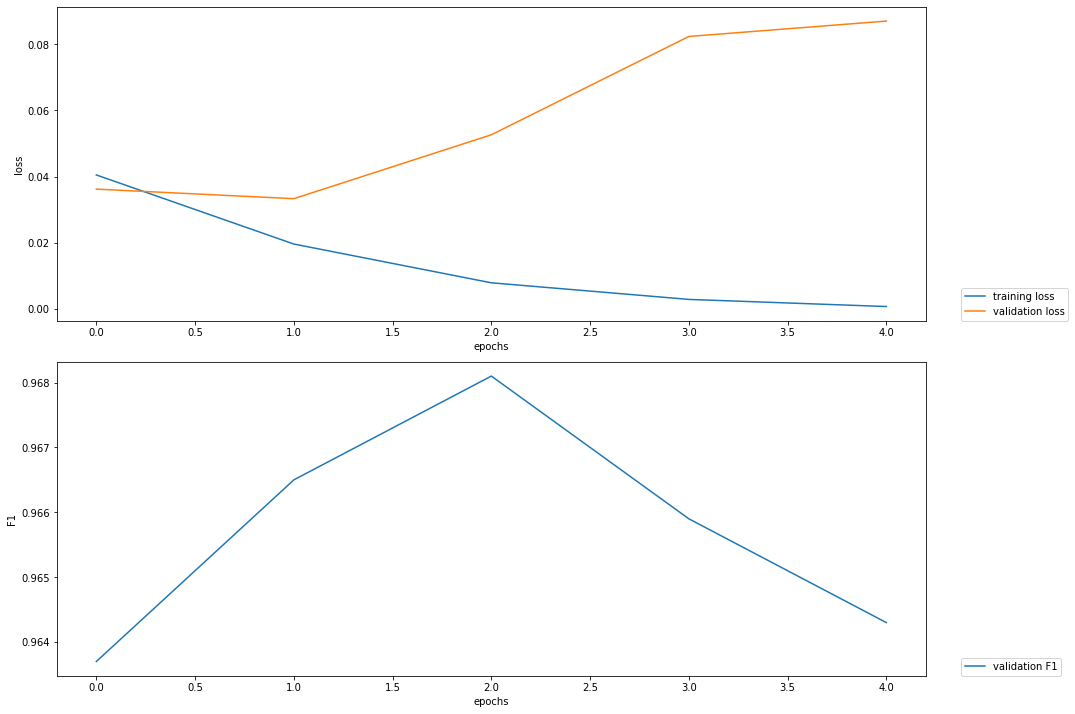

2022-05-08 22:42:43,724 Weights plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/weights.png


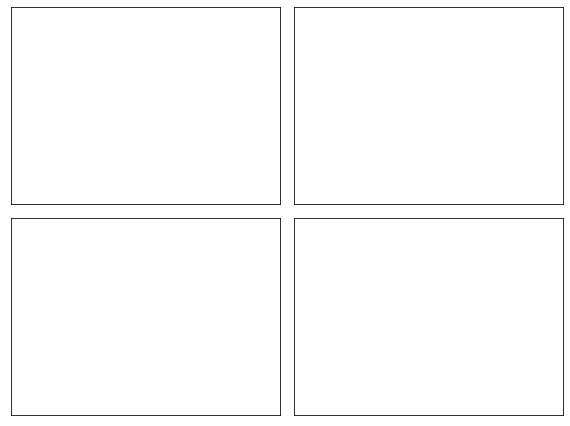

In [49]:
# visualize

plotter = Plotter()
plotter.plot_training_curves(path_model_distilbert+'/loss.tsv')
plotter.plot_weights(path_model_distilbert+'/weights.txt')